### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
dataset_dir = '/content'
classes_dir = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/ANNDL/Challenge1/training_dataset_homework1.zip'

{'Species1': 186, 'Species2': 532, 'Species3': 515, 'Species4': 511, 'Species5': 531, 'Species6': 222, 'Species7': 537, 'Species8': 508}


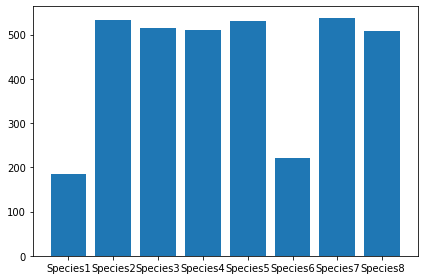

In [ ]:
# class count

counts = {}

for dir in classes_dir:
  counts[dir] = len(os.listdir(os.path.join('/content/training_data_final', dir)))

print(counts)

ind = np.arange(len(counts))

plt.bar(ind, list(counts.values()))
plt.xticks(ind, list(counts.keys()))
plt.tight_layout()
plt.show()

In [ ]:
pip install split-folders

In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio("/content/training_data_final", # The location of dataset
                   output="./", # The output location
                   seed=seed, # The number of seed
                   ratio=(.85, .10, .05), # The ratio of splited dataset
                   group_prefix=None, 
                   move=False 
                   )

Copying files: 3542 files [00:00, 8696.87 files/s]


In [ ]:
import shutil

In [ ]:
source = '/content/test'
destination = '/content/val'

for species in classes_dir:
    
    complete_source = os.path.join(source, species)
    complete_dest = os.path.join(destination, species)
    
    allfiles = os.listdir(complete_source)

    for f in allfiles:
        src_path = os.path.join(complete_source, f)
        dst_path = os.path.join(complete_dest, f)
        shutil.move(src_path, dst_path)

In [ ]:
# Dataset folders 
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from sklearn.utils import class_weight

In [ ]:
default_callbacks =[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]

### EfficientNet

In [ ]:
input_shape = (256, 256, 3)
batch_size = 32
num_classes = 8
epochs = 200
learning_rate = 1e-3
patience = 10
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)

In [ ]:
from keras.applications.efficientnet_v2 import preprocess_input

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=45,
                                    height_shift_range=50,
                                    width_shift_range=50,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    fill_mode='reflect',
                                    preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(directory=training_dir,
                                              target_size=(256, 256),
                                              interpolation="bilinear",
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=seed)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = val_datagen.flow_from_directory(directory=validation_dir,
                                          target_size=(256, 256),
                                          interpolation="bilinear",
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=batch_size,
                                          shuffle=True,
                                          seed=seed)

Found 3007 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(train_gen.classes),
                                                  y=train_gen.classes)
train_class_weights = dict(enumerate(class_weights))

In [ ]:
# import base model
base_model = tfk.applications.EfficientNetV2B0(weights='imagenet', input_shape=input_shape, include_top=False)

# Freeze base model
base_model.trainable = False

model = tfk.Sequential()
model.add(base_model)
model.add(tfkl.Flatten())
model.add(tfkl.Dense(units=64, kernel_initializer=tfk.initializers.GlorotUniform(seed)))
model.add(tfkl.Activation("relu"))
model.add(tfkl.BatchNormalization())
model.add(tfkl.Dropout(0.35, seed=seed))
model.add(tfkl.Dense(units=32, kernel_initializer=tfk.initializers.GlorotUniform(seed)))
model.add(tfkl.Activation("relu"))
model.add(tfkl.BatchNormalization())
model.add(tfkl.Dropout(0.35, seed=seed))
model.add(
    tfkl.Dense(units=num_classes, activation="softmax",
                kernel_initializer=tfk.initializers.GlorotUniform(seed)))

model.summary()

24274472/24274472 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 8, 8, 1280)       5919312   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 64)                5242944   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                         

In [ ]:
patience = 10
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)

In [ ]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')
efficient_history_tl = model.fit(
    x=train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[early_stopping],
    class_weight=train_class_weights
).history

Epoch 1/200
100/100 [==============================] - 69s 493ms/step - loss: 2.6443 - accuracy: 0.1916 - val_loss: 1.8575 - val_accuracy: 0.2869
Epoch 2/200
100/100 [==============================] - 47s 472ms/step - loss: 2.2196 - accuracy: 0.2806 - val_loss: 1.6784 - val_accuracy: 0.3482
Epoch 3/200
100/100 [==============================] - 47s 471ms/step - loss: 2.0562 - accuracy: 0.3117 - val_loss: 1.5469 - val_accuracy: 0.3872
Epoch 4/200
100/100 [==============================] - 50s 499ms/step - loss: 1.9460 - accuracy: 0.3399 - val_loss: 1.4547 - val_accuracy: 0.4596
Epoch 5/200
100/100 [==============================] - 47s 474ms/step - loss: 1.8207 - accuracy: 0.3754 - val_loss: 1.4160 - val_accuracy: 0.4540
Epoch 6/200
100/100 [==============================] - 47s 470ms/step - loss: 1.8032 - accuracy: 0.3849 - val_loss: 1.3782 - val_accuracy: 0.4652
Epoch 7/200
100/100 [==============================] - 50s 505ms/step - loss: 1.7203 - accuracy: 0.4021 - val_loss: 1.3462 -

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/ANNDL/Challenge1/Experiments/efficientnet_tl2")

In [ ]:
model = tfk.models.load_model('/content/drive/MyDrive/Colab Notebooks/ANNDL/Challenge1/Experiments/efficientnet_tl2')

In [ ]:
#base_model.trainable = True
model.get_layer('efficientnetv2-b0').trainable = True

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')
efficient_history_ft = model.fit(
    x=train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[early_stopping],
    class_weight=train_class_weights
).history

Epoch 1/200
100/100 [==============================] - 70s 556ms/step - loss: 2.4526 - accuracy: 0.2419 - val_loss: 1.9461 - val_accuracy: 0.2953
Epoch 2/200
100/100 [==============================] - 52s 523ms/step - loss: 2.2761 - accuracy: 0.2686 - val_loss: 1.7246 - val_accuracy: 0.3760
Epoch 3/200
100/100 [==============================] - 52s 520ms/step - loss: 2.1010 - accuracy: 0.2994 - val_loss: 1.6172 - val_accuracy: 0.4123
Epoch 4/200
100/100 [==============================] - 52s 521ms/step - loss: 1.9934 - accuracy: 0.3299 - val_loss: 1.5576 - val_accuracy: 0.4373
Epoch 5/200
100/100 [==============================] - 55s 550ms/step - loss: 1.9187 - accuracy: 0.3516 - val_loss: 1.4857 - val_accuracy: 0.4708
Epoch 6/200
100/100 [==============================] - 52s 521ms/step - loss: 1.8632 - accuracy: 0.3648 - val_loss: 1.4330 - val_accuracy: 0.4847
Epoch 7/200
100/100 [==============================] - 52s 519ms/step - loss: 1.8098 - accuracy: 0.3792 - val_loss: 1.3954 -

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/ANNDL/Challenge1/Experiments/efficientnet_ft2")

### Performance Evaluation

In [ ]:
model = tfk.models.load_model("/content/drive/MyDrive/Colab Notebooks/ANNDL/Challenge1/Experiments/efficientnet_ft2")

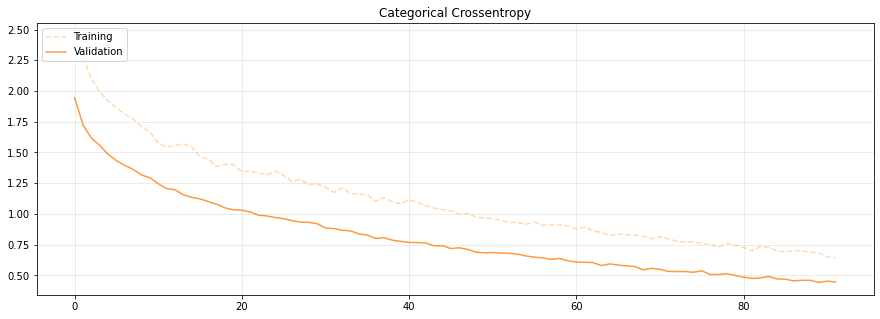

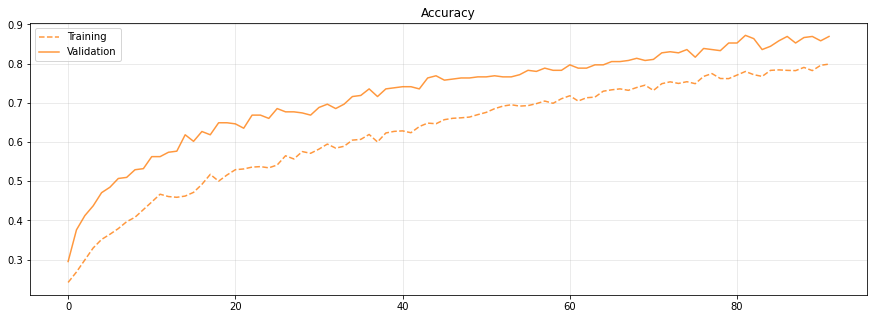

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(efficient_history_ft['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(efficient_history_ft['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')

plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(efficient_history_ft['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(efficient_history_ft['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')

plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

#plt.savefig('loss-accuracy_graphs')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(directory=test_dir,
                                          target_size=(256, 256),
                                          interpolation="bilinear",
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=batch_size,
                                          shuffle=True,
                                          seed=seed)

Found 184 images belonging to 8 classes.


In [ ]:
test_l = len(test_gen) * batch_size
print(test_l)
predictions = np.zeros((test_l,))
y_test = np.zeros((test_l,))

s = 0
for X, y in test_gen:
    y_idx = np.argmax(y, axis=-1)
    p_idx = np.argmax(model.predict(X), axis=-1)
    l = len(y_idx)
    if s + l >= test_l:
        break
    y_test[s:s + l] = y_idx
    predictions[s:s + l] = p_idx
    s += l

predictions = predictions[:s]
y_test = y_test[:s]
predictions.shape

192
1/1 [==============================] - 0s 40ms/step


(184,)

Accuracy: 0.8696
Precision: 0.8569
Recall: 0.8509
F1: 0.8477


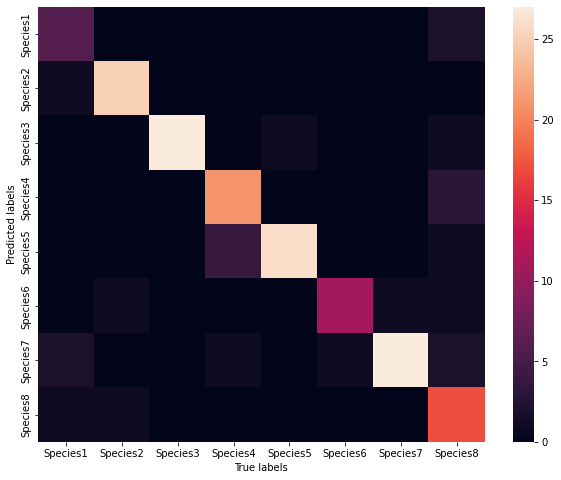

In [ ]:
cm = confusion_matrix(y_test, predictions)

# Compute the classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes_dir, yticklabels=classes_dir)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
#plt.savefig('confusion_matrix.png')
plt.show()